## XGBoost
XGBoost (Extreme Gradient Boosting) is a gradient boosting framework that often outperforms traditional ensemble methods like Random Forest in many scenarios. These are some of the pros of using XGBoost over Random Forest

- Boosting vs. Bagging:
Random Forest uses bagging—building multiple independent trees on different random subsets of data and averaging their predictions. XGBoost, on the other hand, uses boosting, where trees are built sequentially to correct the errors of previous trees. This sequential learning can often capture complex patterns better.
- Regularization and Overfitting Control:
XGBoost includes built-in regularization (both L1 and L2), which helps reduce overfitting. This can be particularly useful when working with high-dimensional feature spaces (like those obtained from deep CNN features) where overfitting is a common issue.
- Handling of Sparse Data and Missing Values:
XGBoost has robust methods for handling missing data and sparse inputs, which might be beneficial if your feature extraction isn’t perfect or if some features are less informative.
- Speed and Efficiency:
With optimized parallelization and hardware-aware optimizations, XGBoost is often faster than Random Forest when tuned appropriately—even on large datasets.
- Tuning Flexibility:
The many hyperparameters in XGBoost (e.g., learning rate, maximum depth, subsampling, and regularization parameters) provide flexibility to fine-tune the model to your specific dataset. This fine-grained control can lead to better performance than Random Forest if you invest time in tuning.
- Empirical Performance:
In many structured or tabular data problems (and sometimes even in scenarios where deep features are used for image classification), XGBoost has been shown to achieve state-of-the-art performance.


In [8]:
#############################################
# Chunk 1: Imports, Seeds, and Setup
#############################################
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

#############################################
# Chunk 2: Data Collection and Label Encoding
#############################################
def get_image_paths_and_labels(directory):
    file_paths = []
    labels = []
    # List subdirectories (classes) in sorted order
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    for cls in classes:
        cls_dir = os.path.join(directory, cls)
        for file in os.listdir(cls_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_paths.append(os.path.join(cls_dir, file))
                labels.append(cls)
    return pd.DataFrame({'file_path': file_paths, 'label': labels})

# Define the copied training directory (adjust path as needed)
new_train_dir = os.path.join('intel_dataset_copy', 'seg_train', 'seg_train')
df = get_image_paths_and_labels(new_train_dir)
print("Sample image paths and labels:")
print(df.head())

# Encode labels into numerical values
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.9 MB/s eta 0:00:00a 0:00:01
Sample image paths and labels:
                                           file_path      label
0  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
1  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
2  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
3  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
4  intel_dataset_copy/seg_train/seg_train/buildin...  buildings


In [9]:
#############################################
# Chunk 3: Feature Extraction using MobileNetV2
#############################################
# Load MobileNetV2 pre-trained on ImageNet without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
# Use Global Average Pooling to create a fixed-length feature vector
gap = GlobalAveragePooling2D()(base_model.output)
feature_extractor = Model(inputs=base_model.input, outputs=gap)

def extract_features(file_path, target_size=(150,150)):
    img = load_img(file_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = feature_extractor.predict(img_array, verbose=0)
    return features.flatten()

# Extract features for all images (using a progress bar)
features = []
for path in tqdm(df['file_path'], desc="Extracting features"):
    feat = extract_features(path)
    features.append(feat)
features = np.array(features)
print("Extracted features shape:", features.shape)

#############################################
# Chunk 4: Feature Scaling
#############################################
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4208200367.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
Extracting features: 100%|████████████████████████████████████| 14016/14016 [16:04<00:00, 14.54it/s]


Extracted features shape: (14016, 1280)


In [31]:
!pip uninstall -y xgboost
!pip install --no-cache-dir xgboost
import sys
!{sys.executable} -m pip install xgboost

Found existing installation: xgboost 2.1.4
Uninstalling xgboost-2.1.4:
  Successfully uninstalled xgboost-2.1.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.6 MB/s eta 0:00:00


XGBoost Model Training

In [35]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

# Define features (X) and labels (y)
X = features_scaled  # Already extracted and scaled
y = df['label_encoded'].values  # Encoded labels

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Now run GridSearchCV
grid_xgb.fit(X_train, y_train)

# Perform GridSearchCV with 5-fold cross-validation
grid_xgb = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Best parameters for XGBoost:", grid_xgb.best_params_)
print("Best cross-validation F1 score for XGBoost:", grid_xgb.best_score_)

# Save the best estimator as final_xgb
final_xgb = grid_xgb.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:12:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:12:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:12:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:12:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time= 1.4min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time= 5.7min
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time= 3.3min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=16.2min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=82.8min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=66.2min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time=23.7min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time=47.5min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time= 5.5min
[CV] END ....learning_rate=0.2, max_depth=7, n_estimators=50; total time= 9.0min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time=28.7min
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time= 1.4min
[CV] END ..learning_rate=0.0

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:22:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time= 2.7min
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time= 3.2min
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time= 3.5min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=15.6min
[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time=58.0min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=77.9min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=13.5min
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=15.4min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time=52.3min
[CV] END ....learning_rate=0.2, max_depth=5, n_estimators=50; total time= 3.0min
[CV] END ....learning_rate=0.2, max_depth=5, n_estimators=50; total time= 3.0min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time= 9.2min
[CV] END ...learning_rate=0.

Evaluation with Confusion Matrix and Classification Report

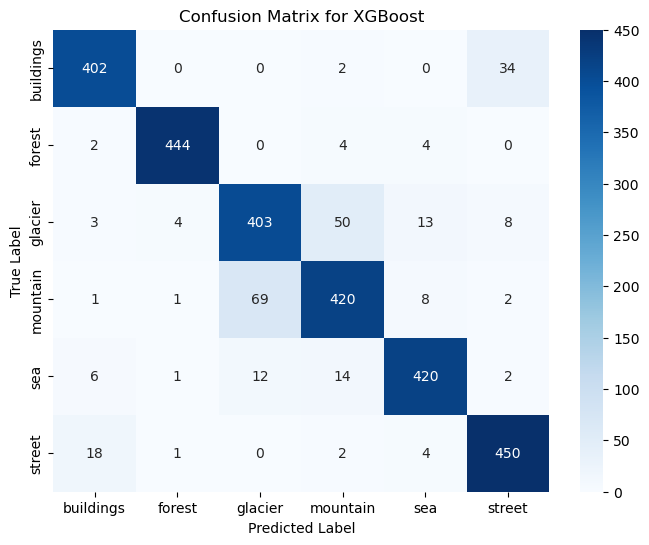

Classification Report for XGBoost:
              precision    recall  f1-score   support

   buildings       0.93      0.92      0.92       438
      forest       0.98      0.98      0.98       454
     glacier       0.83      0.84      0.84       481
    mountain       0.85      0.84      0.85       501
         sea       0.94      0.92      0.93       455
      street       0.91      0.95      0.93       475

    accuracy                           0.91      2804
   macro avg       0.91      0.91      0.91      2804
weighted avg       0.91      0.91      0.91      2804

Weighted F1 Score for XGBoost: 0.9054398750329047


In [37]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set using the trained XGBoost model
y_pred_xgb = final_xgb.predict(X_test)

# Compute the confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8,6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost')
plt.show()

# Print classification report and weighted F1 score
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))
print("Weighted F1 Score for XGBoost:", f1_score(y_test, y_pred_xgb, average='weighted'))

Visualization of XGBoost Predictions on Test Set Images

/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNe

/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))


/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNe

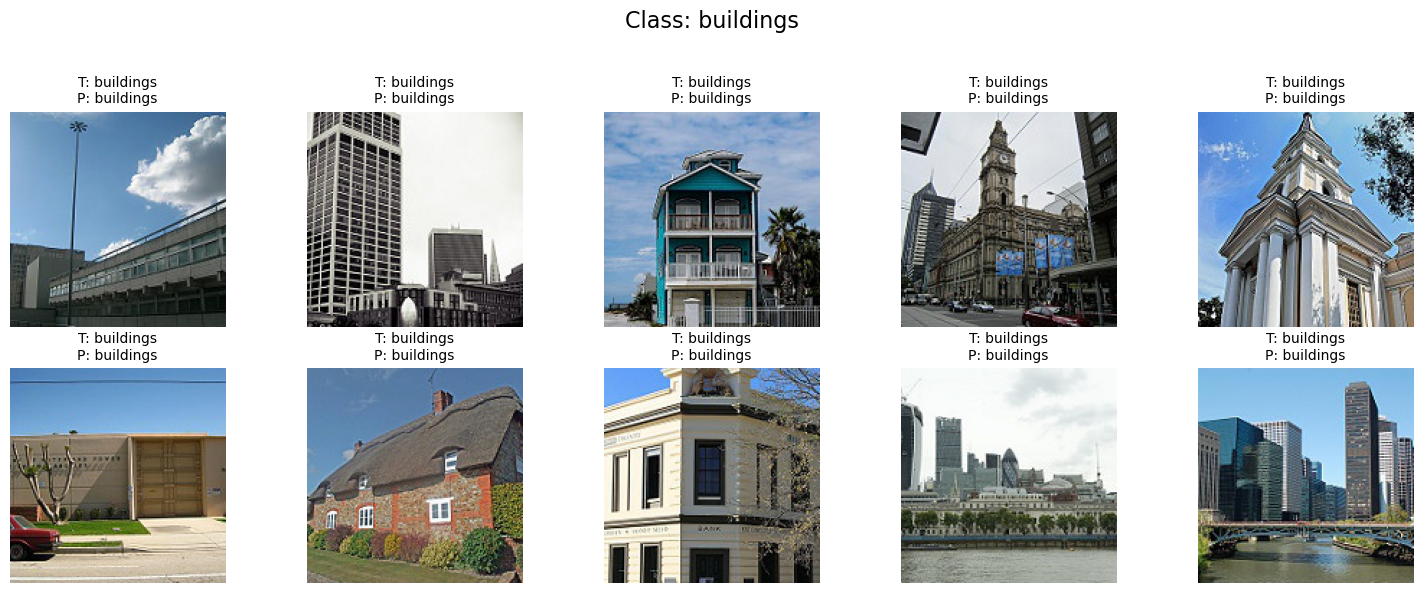

--------------------------------------------------------------------------------


/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNe

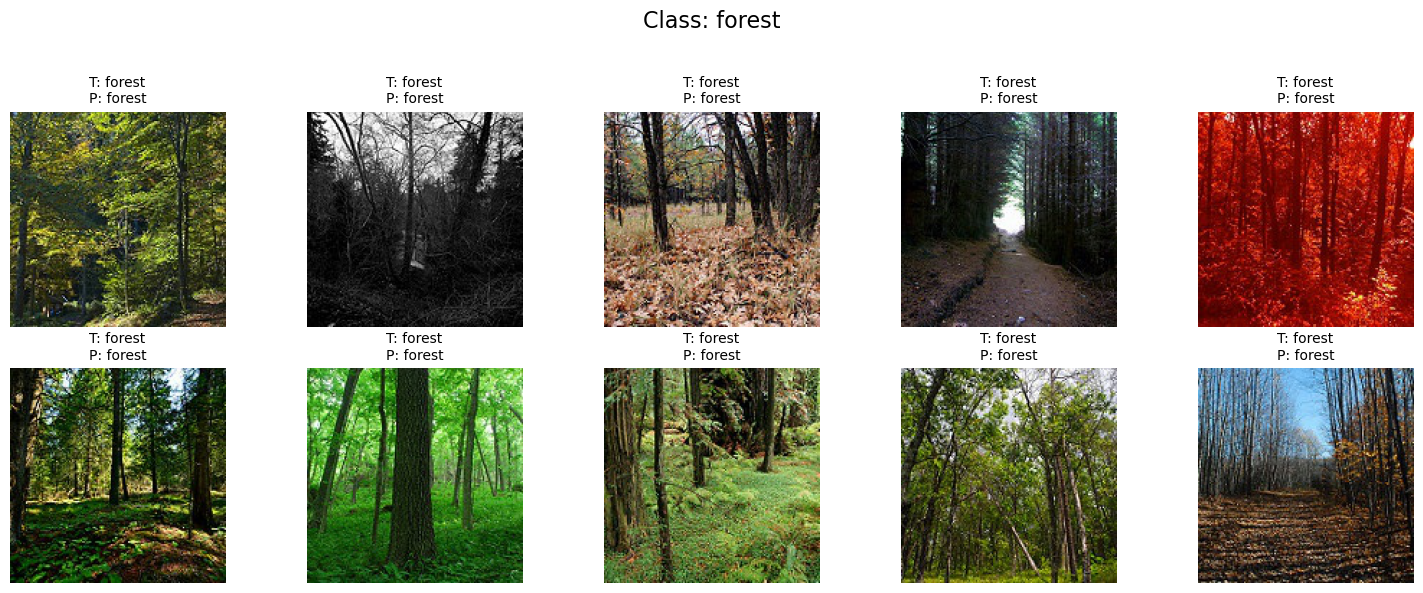

--------------------------------------------------------------------------------


/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNe

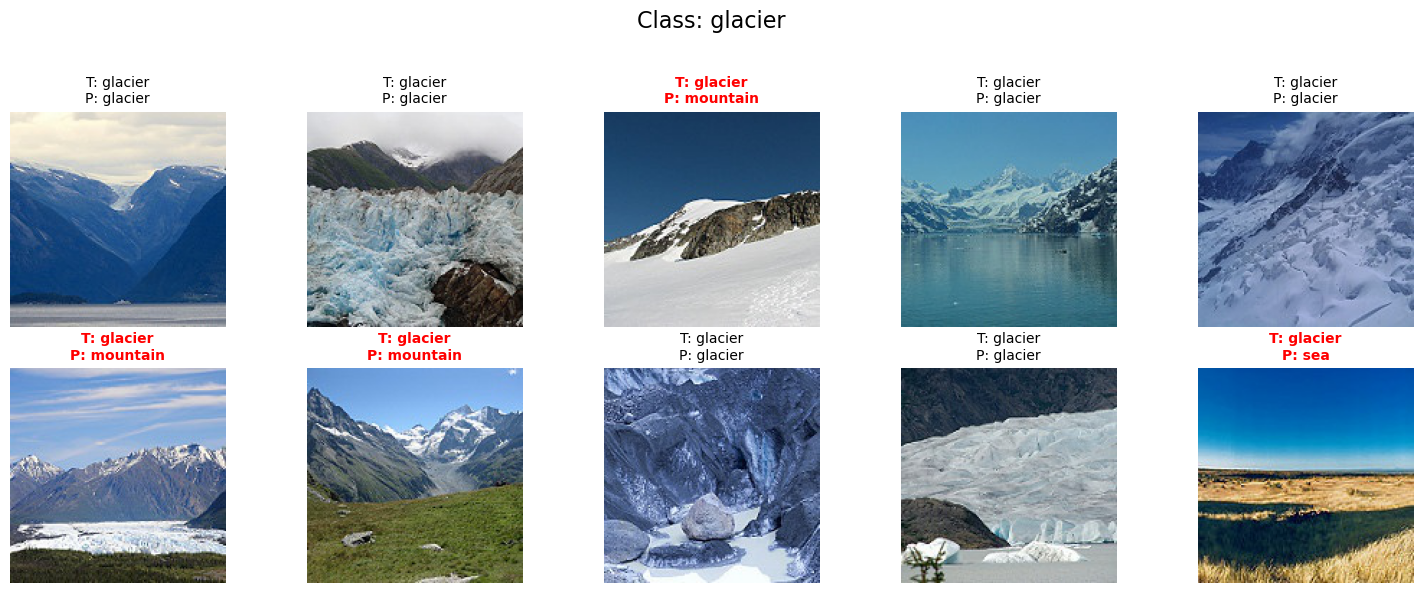

--------------------------------------------------------------------------------


/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNe

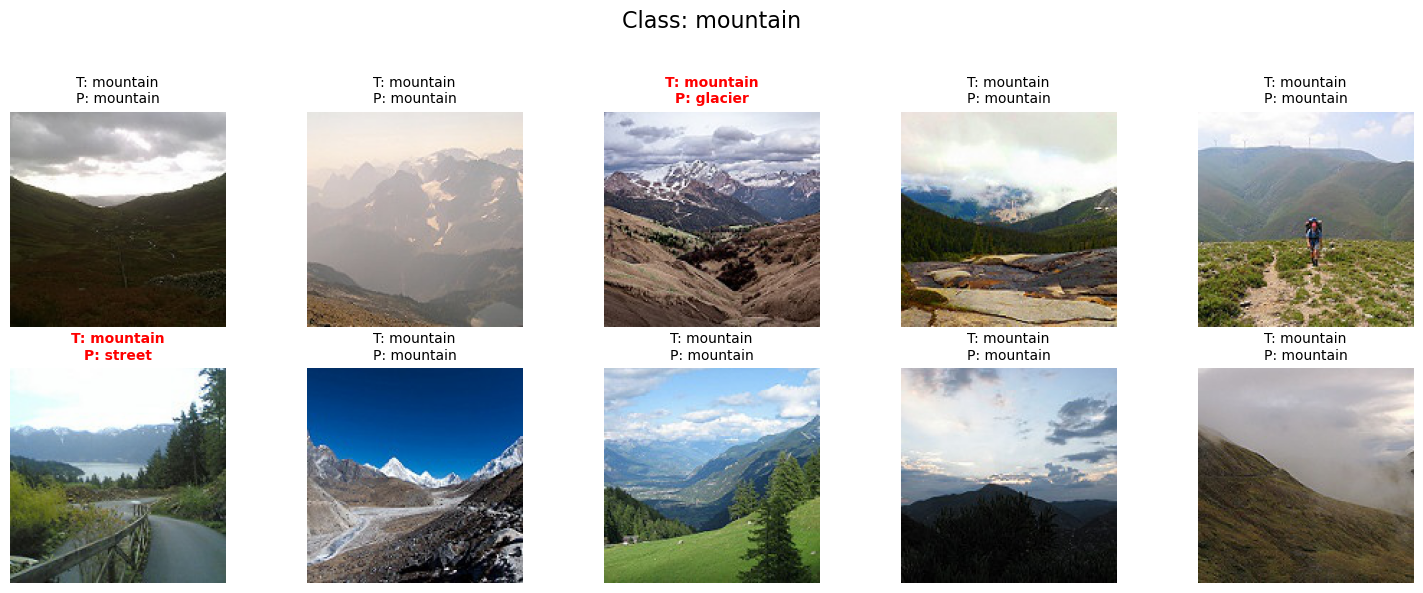

--------------------------------------------------------------------------------


/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNe

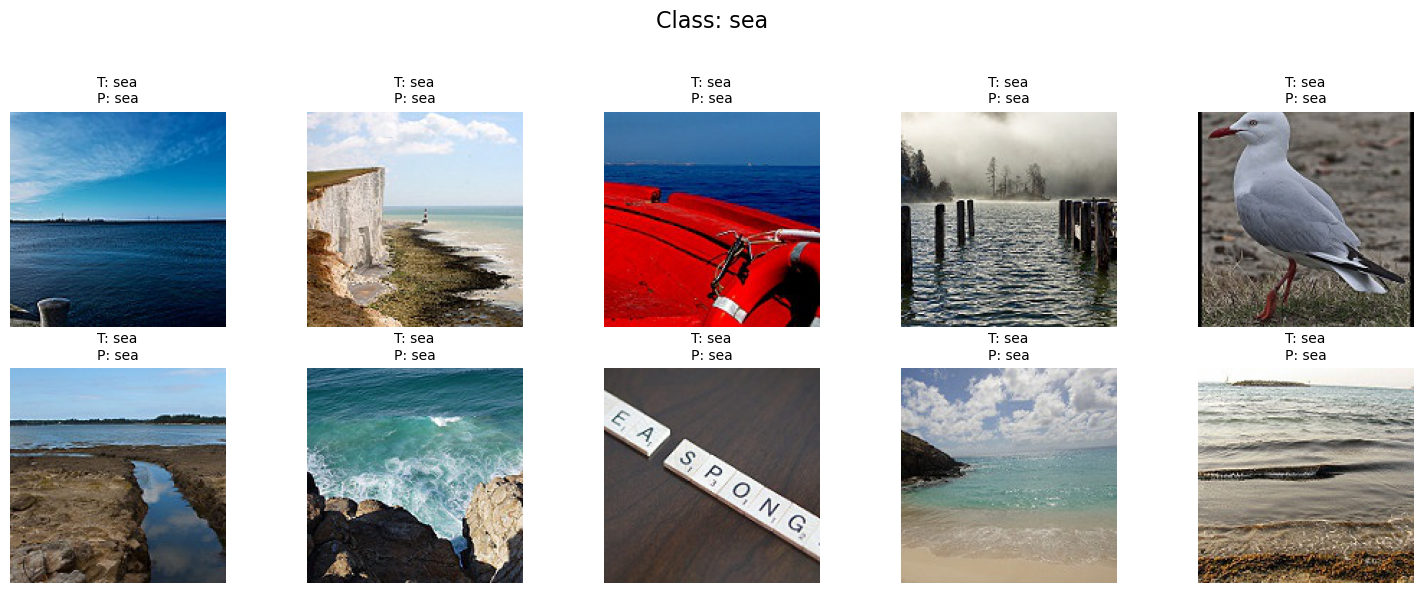

--------------------------------------------------------------------------------


/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2984/4213462691.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNe

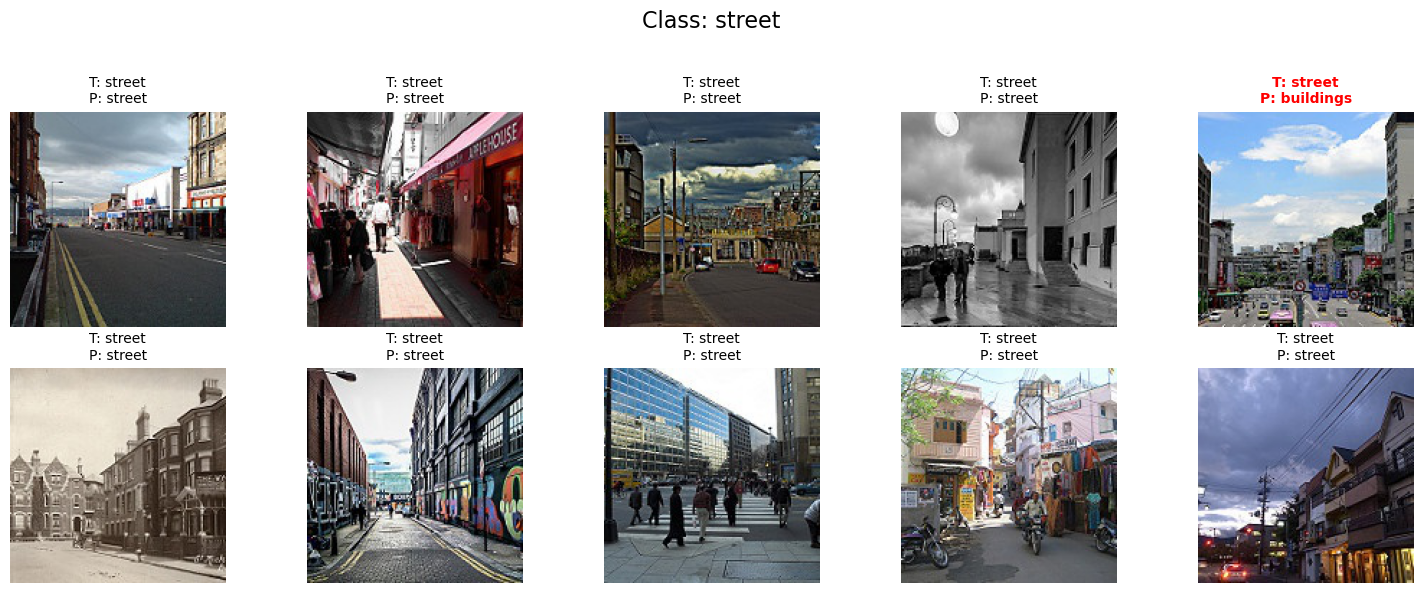

--------------------------------------------------------------------------------


In [39]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# If not already defined, here is a sample extract_features function using MobileNetV2:
def extract_features(file_path, target_size=(150,150)):
    # Reuse the global feature_extractor if defined; otherwise, create it.
    from tensorflow.keras.applications import MobileNetV2
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    from tensorflow.keras.layers import GlobalAveragePooling2D
    from tensorflow.keras.models import Model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
    gap = GlobalAveragePooling2D()(base_model.output)
    feature_extractor = Model(inputs=base_model.input, outputs=gap)
    img = load_img(file_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = feature_extractor.predict(img_array, verbose=0)
    return features.flatten()

# Visualization function for XGBoost predictions
def display_xgb_predictions_grid(num_images=10, rows=2, cols=5, target_size=(150,150)):
    # Set random seed for reproducibility
    random.seed(42)
    
    # Define the copied test directory
    new_test_dir = os.path.join('intel_dataset_copy', 'seg_test', 'seg_test')
    # Get sorted list of classes
    classes = sorted([d for d in os.listdir(new_test_dir) if os.path.isdir(os.path.join(new_test_dir, d))])
    
    for cls in classes:
        class_dir = os.path.join(new_test_dir, cls)
        # Get a sorted list of image files for this class
        images = sorted([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        # Randomly select up to num_images images
        selected = random.sample(images, min(num_images, len(images)))
        
        # Create subplots: grid of rows x cols for current class
        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
        fig.suptitle(f"Class: {cls}", fontsize=16)
        axes = axes.flatten()
        
        for ax, img_file in zip(axes, selected):
            img_path = os.path.join(class_dir, img_file)
            # Load image for display
            img = load_img(img_path, target_size=target_size)
            # Extract features and scale them
            feat = extract_features(img_path, target_size=target_size)
            feat_scaled = scaler.transform(feat.reshape(1, -1))
            # Predict the label using the final XGBoost model
            pred_encoded = final_xgb.predict(feat_scaled)[0]
            pred_class = le.inverse_transform([pred_encoded])[0]
            true_class = cls
            
            title_text = f"T: {true_class}\nP: {pred_class}"
            if pred_class != true_class:
                ax.set_title(title_text, fontweight='bold', color='red', fontsize=10)
            else:
                ax.set_title(title_text, fontsize=10)
            ax.imshow(img)
            ax.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        print("-" * 80)

# Call the visualization function
display_xgb_predictions_grid(num_images=10, rows=2, cols=5, target_size=(150,150))